Предлагается самостоятельно проанализировать то, что было изменено, чтобы улучшить качество модели (и обратить на это внимание). ? 

Добавлено 2 дополнительных скрытых слоя.

Увеличена нелинейность модели за счет большего числа активаций ReLU
learning rate увеличен в 10 раз (с 1e-4 до 1e-3).

Количество эпох удвоено (с 500 до 1000).
Глубокая архитектура (3 скрытых слоя вместо 1) → лучшее разделение классов.

Оптимизированный learning rate → ускорение обучения без расходимости.

Увеличение эпох → модель успевает найти оптимальные веса.

Решил сам попробовать 

Train shape: (240, 2), Test shape: (60, 2)


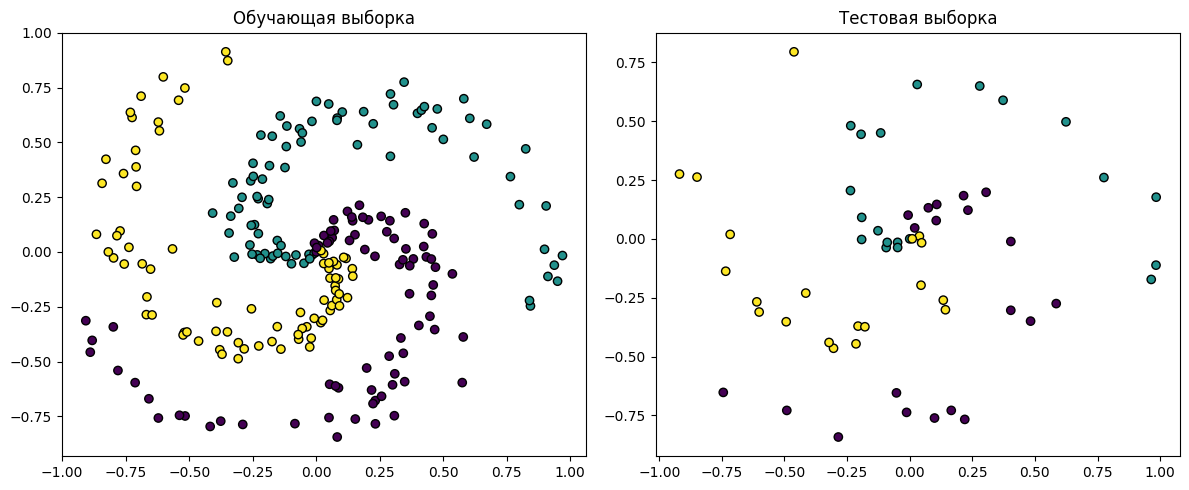


Обучение простой модели:
Epoch    0 | Train Loss: 1.1317 | Test Loss: 1.1237
Epoch   50 | Train Loss: 0.8854 | Test Loss: 0.8899
Epoch  100 | Train Loss: 0.7584 | Test Loss: 0.7680
Epoch  150 | Train Loss: 0.6792 | Test Loss: 0.6937
Epoch  200 | Train Loss: 0.6175 | Test Loss: 0.6401
Epoch  250 | Train Loss: 0.5625 | Test Loss: 0.5936
Epoch  300 | Train Loss: 0.5103 | Test Loss: 0.5495
Epoch  350 | Train Loss: 0.4617 | Test Loss: 0.5066
Epoch  400 | Train Loss: 0.4174 | Test Loss: 0.4671
Epoch  450 | Train Loss: 0.3779 | Test Loss: 0.4311
Epoch  500 | Train Loss: 0.3432 | Test Loss: 0.3990
Epoch  550 | Train Loss: 0.3127 | Test Loss: 0.3701
Epoch  600 | Train Loss: 0.2862 | Test Loss: 0.3443
Epoch  650 | Train Loss: 0.2632 | Test Loss: 0.3216
Epoch  700 | Train Loss: 0.2431 | Test Loss: 0.3014
Epoch  750 | Train Loss: 0.2256 | Test Loss: 0.2834
Epoch  800 | Train Loss: 0.2102 | Test Loss: 0.2675
Epoch  850 | Train Loss: 0.1964 | Test Loss: 0.2535
Epoch  900 | Train Loss: 0.1842 | Test

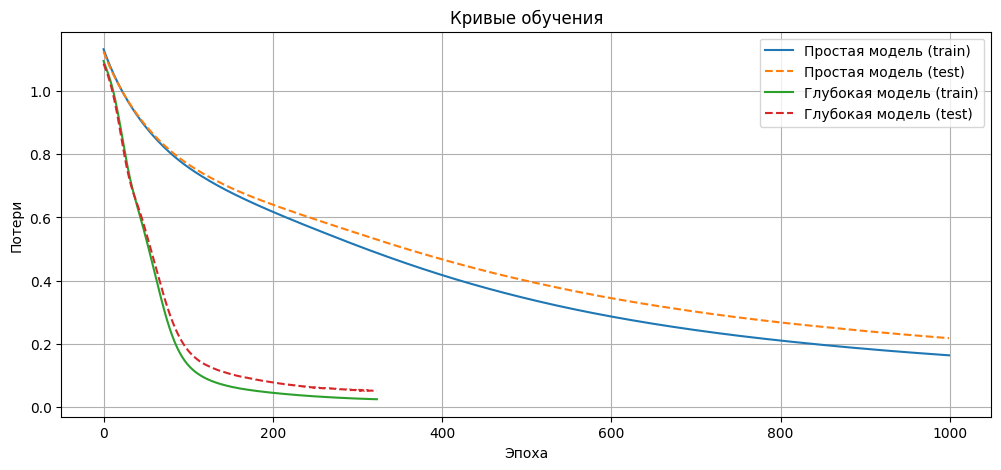


Оценка простой модели на тестовых данных:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.90      0.92        20
           2       0.90      0.95      0.93        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60


Confusion Matrix:
[[19  1  0]
 [ 0 18  2]
 [ 1  0 19]]


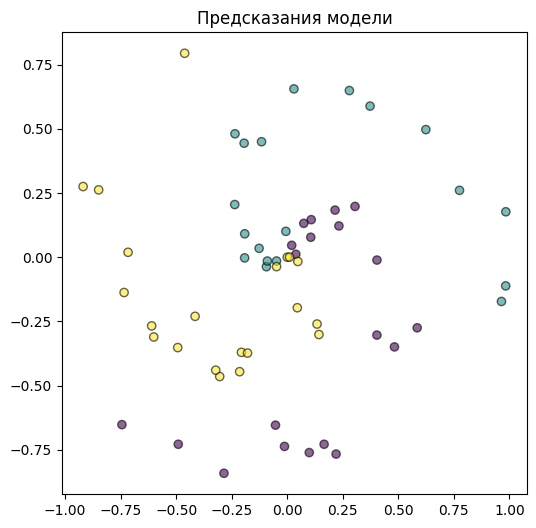


Оценка глубокой модели на тестовых данных:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.95      0.97        20
           2       1.00      0.95      0.97        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Confusion Matrix:
[[20  0  0]
 [ 1 19  0]
 [ 1  0 19]]


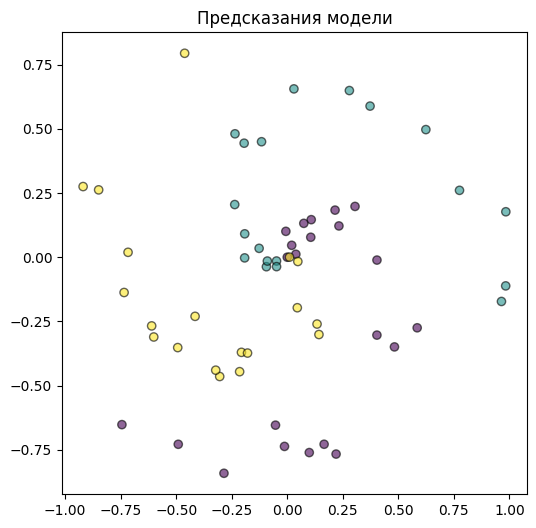

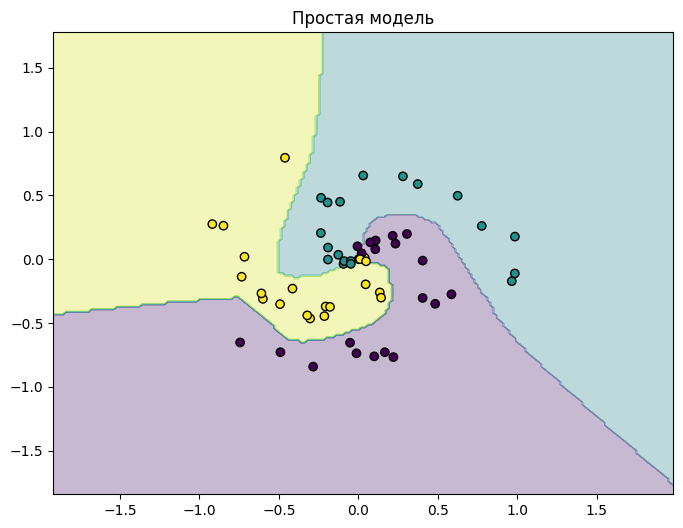

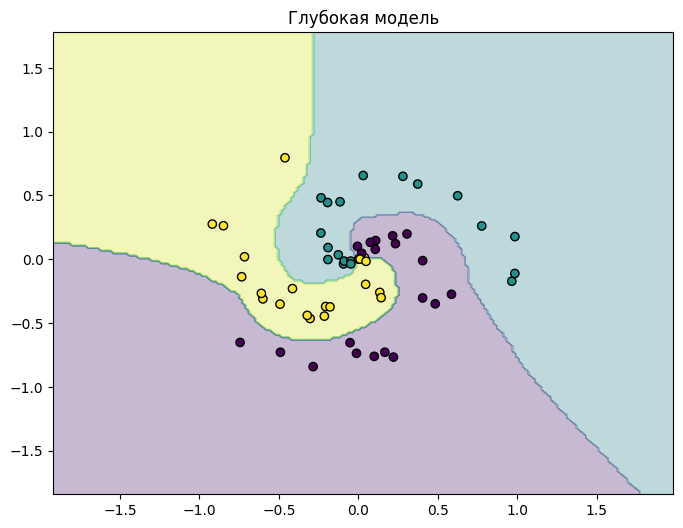

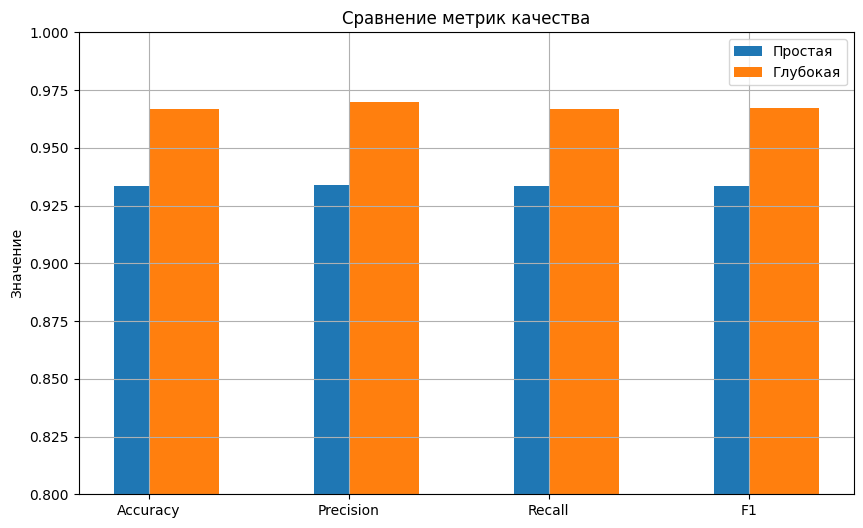

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, 
                             classification_report)

# 1. Улучшенная генерация данных с разделением на train/test
def generate_spiral_data(samples_per_class=100, n_classes=3, noise=0.2, test_size=0.2):
    X = np.zeros((samples_per_class * n_classes, 2))
    y = np.zeros(samples_per_class * n_classes, dtype='uint8')
    
    for class_id in range(n_classes):
        ix = range(samples_per_class * class_id, samples_per_class * (class_id + 1))
        r = np.linspace(0.0, 1, samples_per_class)
        t = np.linspace(class_id * 4, (class_id + 1) * 4, samples_per_class) + np.random.randn(samples_per_class) * noise
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_id
    
    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    return X_train, X_test, y_train, y_test

# Генерация данных
X_train, X_test, y_train, y_test = generate_spiral_data(noise=0.3)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Визуализация данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k')
plt.title('Обучающая выборка')
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolors='k')
plt.title('Тестовая выборка')
plt.tight_layout()
plt.show()

# 2. Конфигурация обучения
class TrainingConfig:
    batch_size = 64
    epochs = 1000
    learning_rate = 1e-3
    hidden_size = 100
    early_stop_patience = 20

# 3. Универсальная функция обучения
def train_model(model, X_train, y_train, X_test, y_test, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Преобразование данных в тензоры
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.LongTensor(y_test).to(device)
    
    # Оптимизатор и планировщик
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    criterion = nn.CrossEntropyLoss()
    
    # Логирование
    train_loss, test_loss = [], []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(config.epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_t)
            t_loss = criterion(test_outputs, y_test_t)
        
        # Логирование
        train_loss.append(loss.item())
        test_loss.append(t_loss.item())
        scheduler.step(t_loss)
        
        # Ранняя остановка
        if t_loss < best_loss:
            best_loss = t_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= config.early_stop_patience:
            print(f"Ранняя остановка на эпохе {epoch}")
            break
            
        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Test Loss: {t_loss.item():.4f}")
    
    return train_loss, test_loss

# 4. Модели
simple_net = nn.Sequential(
    nn.Linear(2, TrainingConfig.hidden_size),
    nn.ReLU(),
    nn.Linear(TrainingConfig.hidden_size, 3)
)

deep_net = nn.Sequential(
    nn.Linear(2, TrainingConfig.hidden_size),
    nn.ReLU(),
    nn.Linear(TrainingConfig.hidden_size, TrainingConfig.hidden_size),
    nn.ReLU(),
    nn.Linear(TrainingConfig.hidden_size, TrainingConfig.hidden_size),
    nn.ReLU(),
    nn.Linear(TrainingConfig.hidden_size, 3)
)

# 5. Обучение моделей
print("\nОбучение простой модели:")
train_loss_simple, test_loss_simple = train_model(simple_net, X_train, y_train, X_test, y_test, TrainingConfig)

print("\nОбучение глубокой модели:")
train_loss_deep, test_loss_deep = train_model(deep_net, X_train, y_train, X_test, y_test, TrainingConfig)

# 6. Визуализация процесса обучения
plt.figure(figsize=(12, 5))
plt.plot(train_loss_simple, label='Простая модель (train)')
plt.plot(test_loss_simple, '--', label='Простая модель (test)')
plt.plot(train_loss_deep, label='Глубокая модель (train)')
plt.plot(test_loss_deep, '--', label='Глубокая модель (test)')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Кривые обучения')
plt.legend()
plt.grid(True)
plt.show()

# 7. Функция оценки модели
def evaluate_model(model, X, y_true):
    device = next(model.parameters()).device
    X_t = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        y_pred = model(X_t).cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', alpha=0.6, edgecolors='k')
    plt.title('Предсказания модели')
    plt.show()

# Оценка моделей
print("\nОценка простой модели на тестовых данных:")
evaluate_model(simple_net, X_test, y_test)

print("\nОценка глубокой модели на тестовых данных:")
evaluate_model(deep_net, X_test, y_test)

# 8. Визуализация 
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    device = next(model.parameters()).device
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    
    with torch.no_grad():
        Z = model(grid_tensor).cpu().numpy()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(simple_net, X_test, y_test, 'Простая модель')
plot_decision_boundary(deep_net, X_test, y_test, 'Глубокая модель')

# 9. Сравнение метрик
def compare_metrics(models, model_names, X_test, y_test):
    results = []
    for model, name in zip(models, model_names):
        X_t = torch.FloatTensor(X_test).to(next(model.parameters()).device)
        with torch.no_grad():
            y_pred = model(X_t).cpu().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        
        results.append({
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted')
        })
    
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    width = 0.35
    
    for i, (res, name) in enumerate(zip(results, model_names)):
        plt.bar(x + i*width/2, [res[m] for m in metrics], width=width, label=name)
    
    plt.xticks(x, metrics)
    plt.ylim(0.8, 1.0)
    plt.title('Сравнение метрик качества')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_metrics([simple_net, deep_net], ['Простая', 'Глубокая'], X_test, y_test)